In [23]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df = pd.read_csv(body)
df.head()


INFO:ibm_botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): iam.eu-gb.bluemix.net


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## 1. Data-preprocessing

**Formatting Data Types**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1048575 non-null object
Warehouse           1048575 non-null object
Product_Category    1048575 non-null object
Date                1037336 non-null object
Order_Demand        1048575 non-null object
dtypes: object(5)
memory usage: 40.0+ MB


In [25]:
#format date column
import datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y/%m/%d')

In [26]:
#remove invalid cahracter for int data type
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype(int)
df['Order_Demand'].dtype

dtype('int64')

**Nan and Missing Columns**

In [27]:
df.columns[df.isna().any()].tolist()

['Date']

In [28]:
df.dropna(axis=0, inplace=True)

**Exploratory Analysis**

<module 'matplotlib.pyplot' from '/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

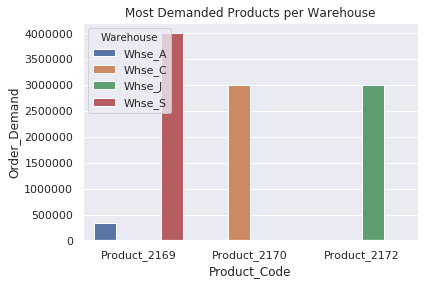

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#aggregate the product_code composition (top 10)
demand_by_product = pd.DataFrame(df.groupby(['Warehouse', 'Product_Code'])['Order_Demand'].sum().sort_values(ascending=False)[0:10])
demand_by_product.reset_index(inplace=True)
demand_by_product = pd.DataFrame(df.groupby('Warehouse')['Product_Code', 'Order_Demand'].max())
demand_by_product.reset_index(inplace=True)

#plot
sns.barplot(x='Product_Code', y='Order_Demand', hue='Warehouse', data=demand_by_product)
sns.set(rc={'figure.figsize':(250,500)})
plt.xticks()
plt.title('Most Demanded Products per Warehouse')
plt

In [30]:
del demand_by_product #clean memory

In [9]:
df.groupby(['Warehouse', 'Product_Code', 'Order_Demand']).count().sort_values('Order_Demand', ascending=False)[0:10]

Product_Category  Date
Warehouse Product_Code Order_Demand                        
Whse_S    Product_1432 4000000                      1     1
Whse_C    Product_1341 3000000                      1     1
Whse_S    Product_1432 3000000                      1     1
Whse_J    Product_1248 3000000                      1     1
                       2560000                      1     1
                       2500000                      1     1
Whse_S    Product_1432 2500000                      4     4
Whse_C    Product_1480 2300000                      1     1
Whse_S    Product_1432 2199000                      1     1
Whse_J    Product_1248 2000000                      3     3

In [10]:
print("Number of unique products: " + str(df['Product_Code'].nunique()))
print("Number of unique product categories: " + str(df['Product_Category'].nunique()))

Number of unique products: 2160
Number of unique product categories: 33


**Formatting Date Data**

In [11]:
#daily demand for each product per warehouse
df.sort_values(by=['Date'], inplace=True)
data = df.copy()
data.set_index('Product_Code')
data = data.groupby(['Date', 'Warehouse', 'Product_Code'])['Order_Demand'].sum()
data = pd.DataFrame(data).reset_index()
data.sort_values(by=['Date'], inplace=True)
data.head()

,Date,Warehouse,Product_Code,Order_Demand
0,2011-01-08,Whse_A,Product_0965,2
1,2011-05-31,Whse_A,Product_1724,108
2,2011-06-24,Whse_S,Product_1521,92000
3,2011-09-02,Whse_C,Product_1507,1250
4,2011-09-27,Whse_C,Product_0608,5


In [12]:
df = data.copy()

## 2. Model Developement

Given the product and product_category variety of the dataset, modelling the original dataset is not logical in scope of computing memory and in aim of aggregate forecasting. Therefore, the forecasting model will take an input of a product code for each individual warehouse.

In [13]:
input_product_code = 'Product_1432' #selected based off exploratory analysis
input_warehouse = 'Whse_S' #selected based off exploratory analysis

df = df[df['Warehouse'] == input_warehouse]
df = df[df['Product_Code'] == input_product_code]
df.head()

,Date,Warehouse,Product_Code,Order_Demand
231,2011-12-21,Whse_S,Product_1432,10000
351,2011-12-26,Whse_S,Product_1432,50000
560,2012-01-02,Whse_S,Product_1432,30000
1370,2012-01-05,Whse_S,Product_1432,2000000
7419,2012-01-24,Whse_S,Product_1432,5000


In [14]:
#!conda install -c conda-forge fbprophet -y
#!pip install plotly

In [15]:
from fbprophet import Prophet
df.reset_index(inplace=True)
df = df[['Date', 'Order_Demand']]
df = df.rename(columns={"Date": "ds", "Order_Demand":"y"})

Importing plotly failed. Interactive plots will not work.


In [16]:
model = Prophet()
model.fit(df)
y = model.make_future_dataframe(periods=365)
y_hat = model.predict(y)

y_hat['yhat'].clip(lower=0, inplace=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/conda/envs/Python36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



## 3. Results

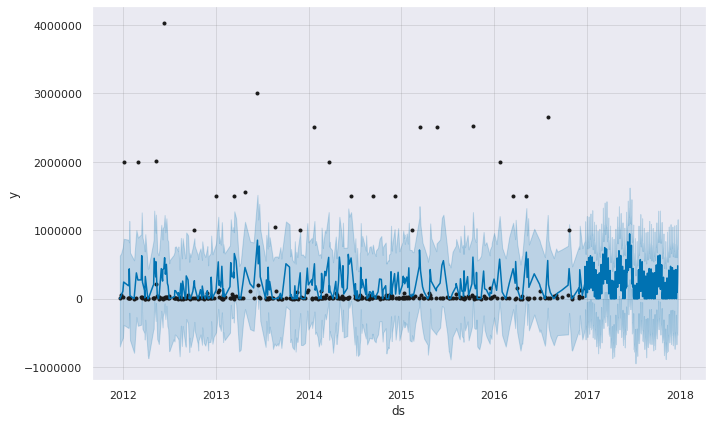

In [17]:
model.plot(y_hat); #prophet plot

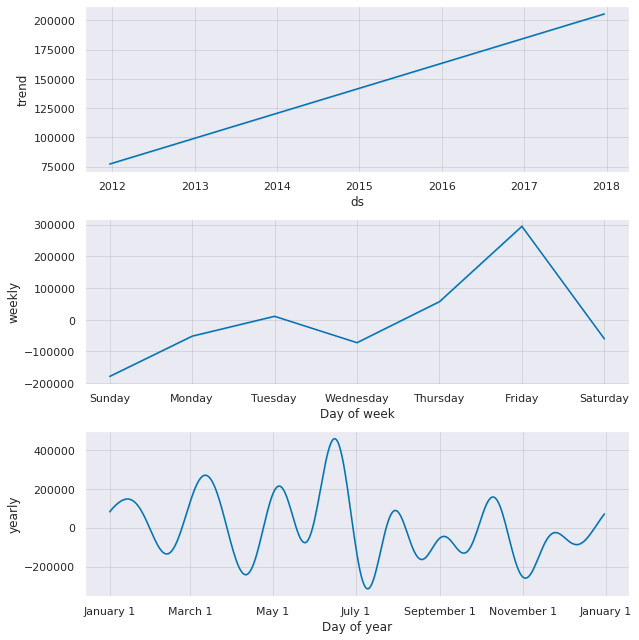

In [18]:
model.plot_components(y_hat);

In [19]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-01-02 00:00:00 and 2015-12-23 00:00:00
/opt/conda/envs/Python36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-14,518340.116203,-142703.153240,1.123554e+06,1000,2014-01-02
1,2014-01-15,395813.777768,-195195.429191,1.039012e+06,3000,2014-01-02
2,2014-01-24,91652.554492,-586729.927185,7.324378e+05,2500000,2014-01-02
3,2014-01-27,-42279.173509,-681718.386628,5.814023e+05,10000,2014-01-02
4,2014-01-30,56933.488807,-581705.609294,7.313204e+05,5000,2014-01-02


In [20]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
201,356 days,3.660131e+11,604990.172363,337639.280744,39.416595,8.507361,0.870968
202,358 days,3.558401e+11,596523.360987,325771.682681,38.874870,8.507361,0.881720
203,359 days,3.455790e+11,587859.668856,313075.047370,37.688386,8.507361,0.892473
204,364 days,3.355378e+11,579256.219811,302041.999516,36.535682,8.507361,0.903226
205,365 days,3.352974e+11,579048.663728,300575.089396,33.171474,8.434372,0.903226


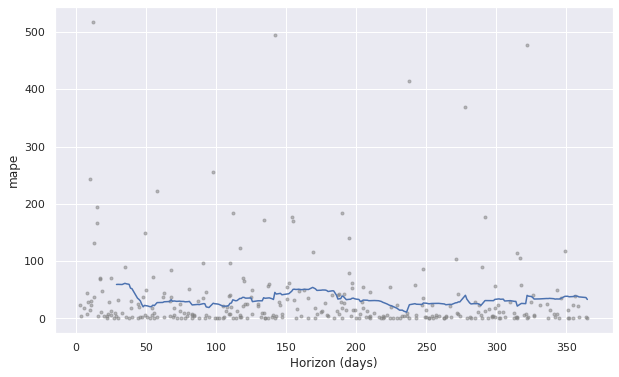

In [21]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape');

In [22]:
print("Mean Absolute Percentage Error (MAPE): " + str(df_p['mape'].iloc[-1].round(2)) + "%")

Mean Absolute Percentage Error (MAPE): 33.17%
